# E-tivity 3 : Gerard O'Rourke, Student number : 24514772
This
workbook is
for E - tivity3.It follows the following structure
1.
The
workbook
environment is setup
1.
The
next
section
has
some
EDA
related
to
this
E - tivity
1.
Each
task
for this E - tivity then follows

Setup

In [145]:


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, auc, precision_recall_fscore_support, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler  # needed for data preparation

print(sklearn.__version__)

# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
#sklearn.set_config(enable_metadata_routing=True)
set_config(transform_output='pandas')


1.6.1


#### Setup Environment
Load the data and keep a copy

In [146]:
# Load the dataset
df = pd.read_csv("./insurance.csv")

# keep a copy
df_original = df

print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (1338, 7)


EDA

In [147]:
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [148]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


In [149]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [150]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [151]:
numerical_attribute = ['age', 'bmi', 'children']

categorical_attribute = ['gender', 'smoker', 'region']

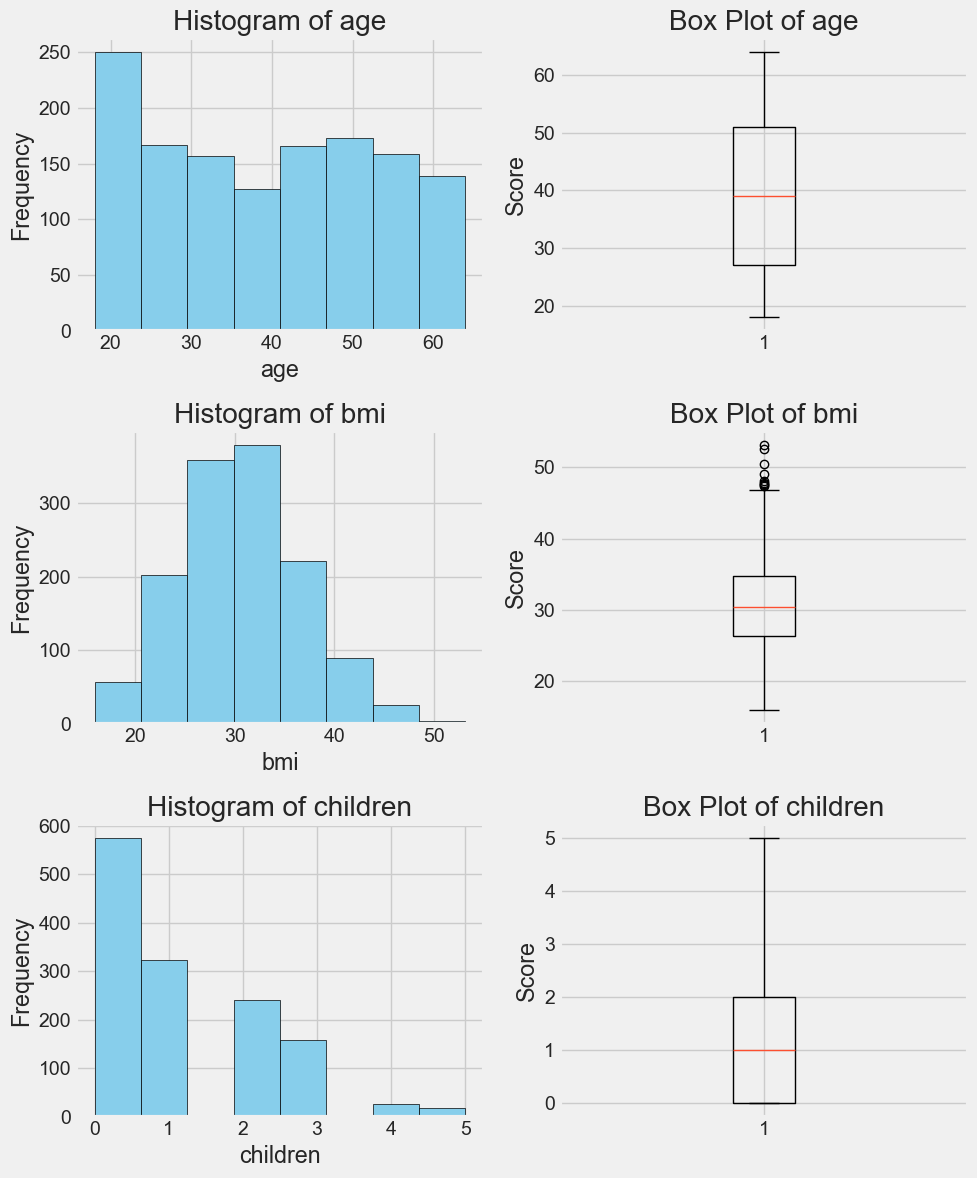

In [152]:
# df.boxplot(column=numerical_attribute)
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(nrows=len(numerical_attribute), ncols=2, figsize=(10, 4 * len(numerical_attribute)))

for row, attribute in enumerate(numerical_attribute):
	# Histogram
	axes[row, 0].hist(df[attribute], bins=8, color='skyblue', edgecolor='black')
	axes[row, 0].set_title(f'Histogram of {attribute}')
	axes[row, 0].set_xlabel(attribute)
	axes[row, 0].set_ylabel('Frequency')

	# Box plot
	axes[row, 1].boxplot(df[attribute], vert=True)
	axes[row, 1].set_title(f'Box Plot of {attribute}')
	axes[row, 1].set_ylabel('Score')

# Display
plt.tight_layout()
plt.show()


In [153]:
df['gender'].value_counts()

gender
male      676
female    662
Name: count, dtype: int64

In [154]:
df['smoker'].value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [155]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

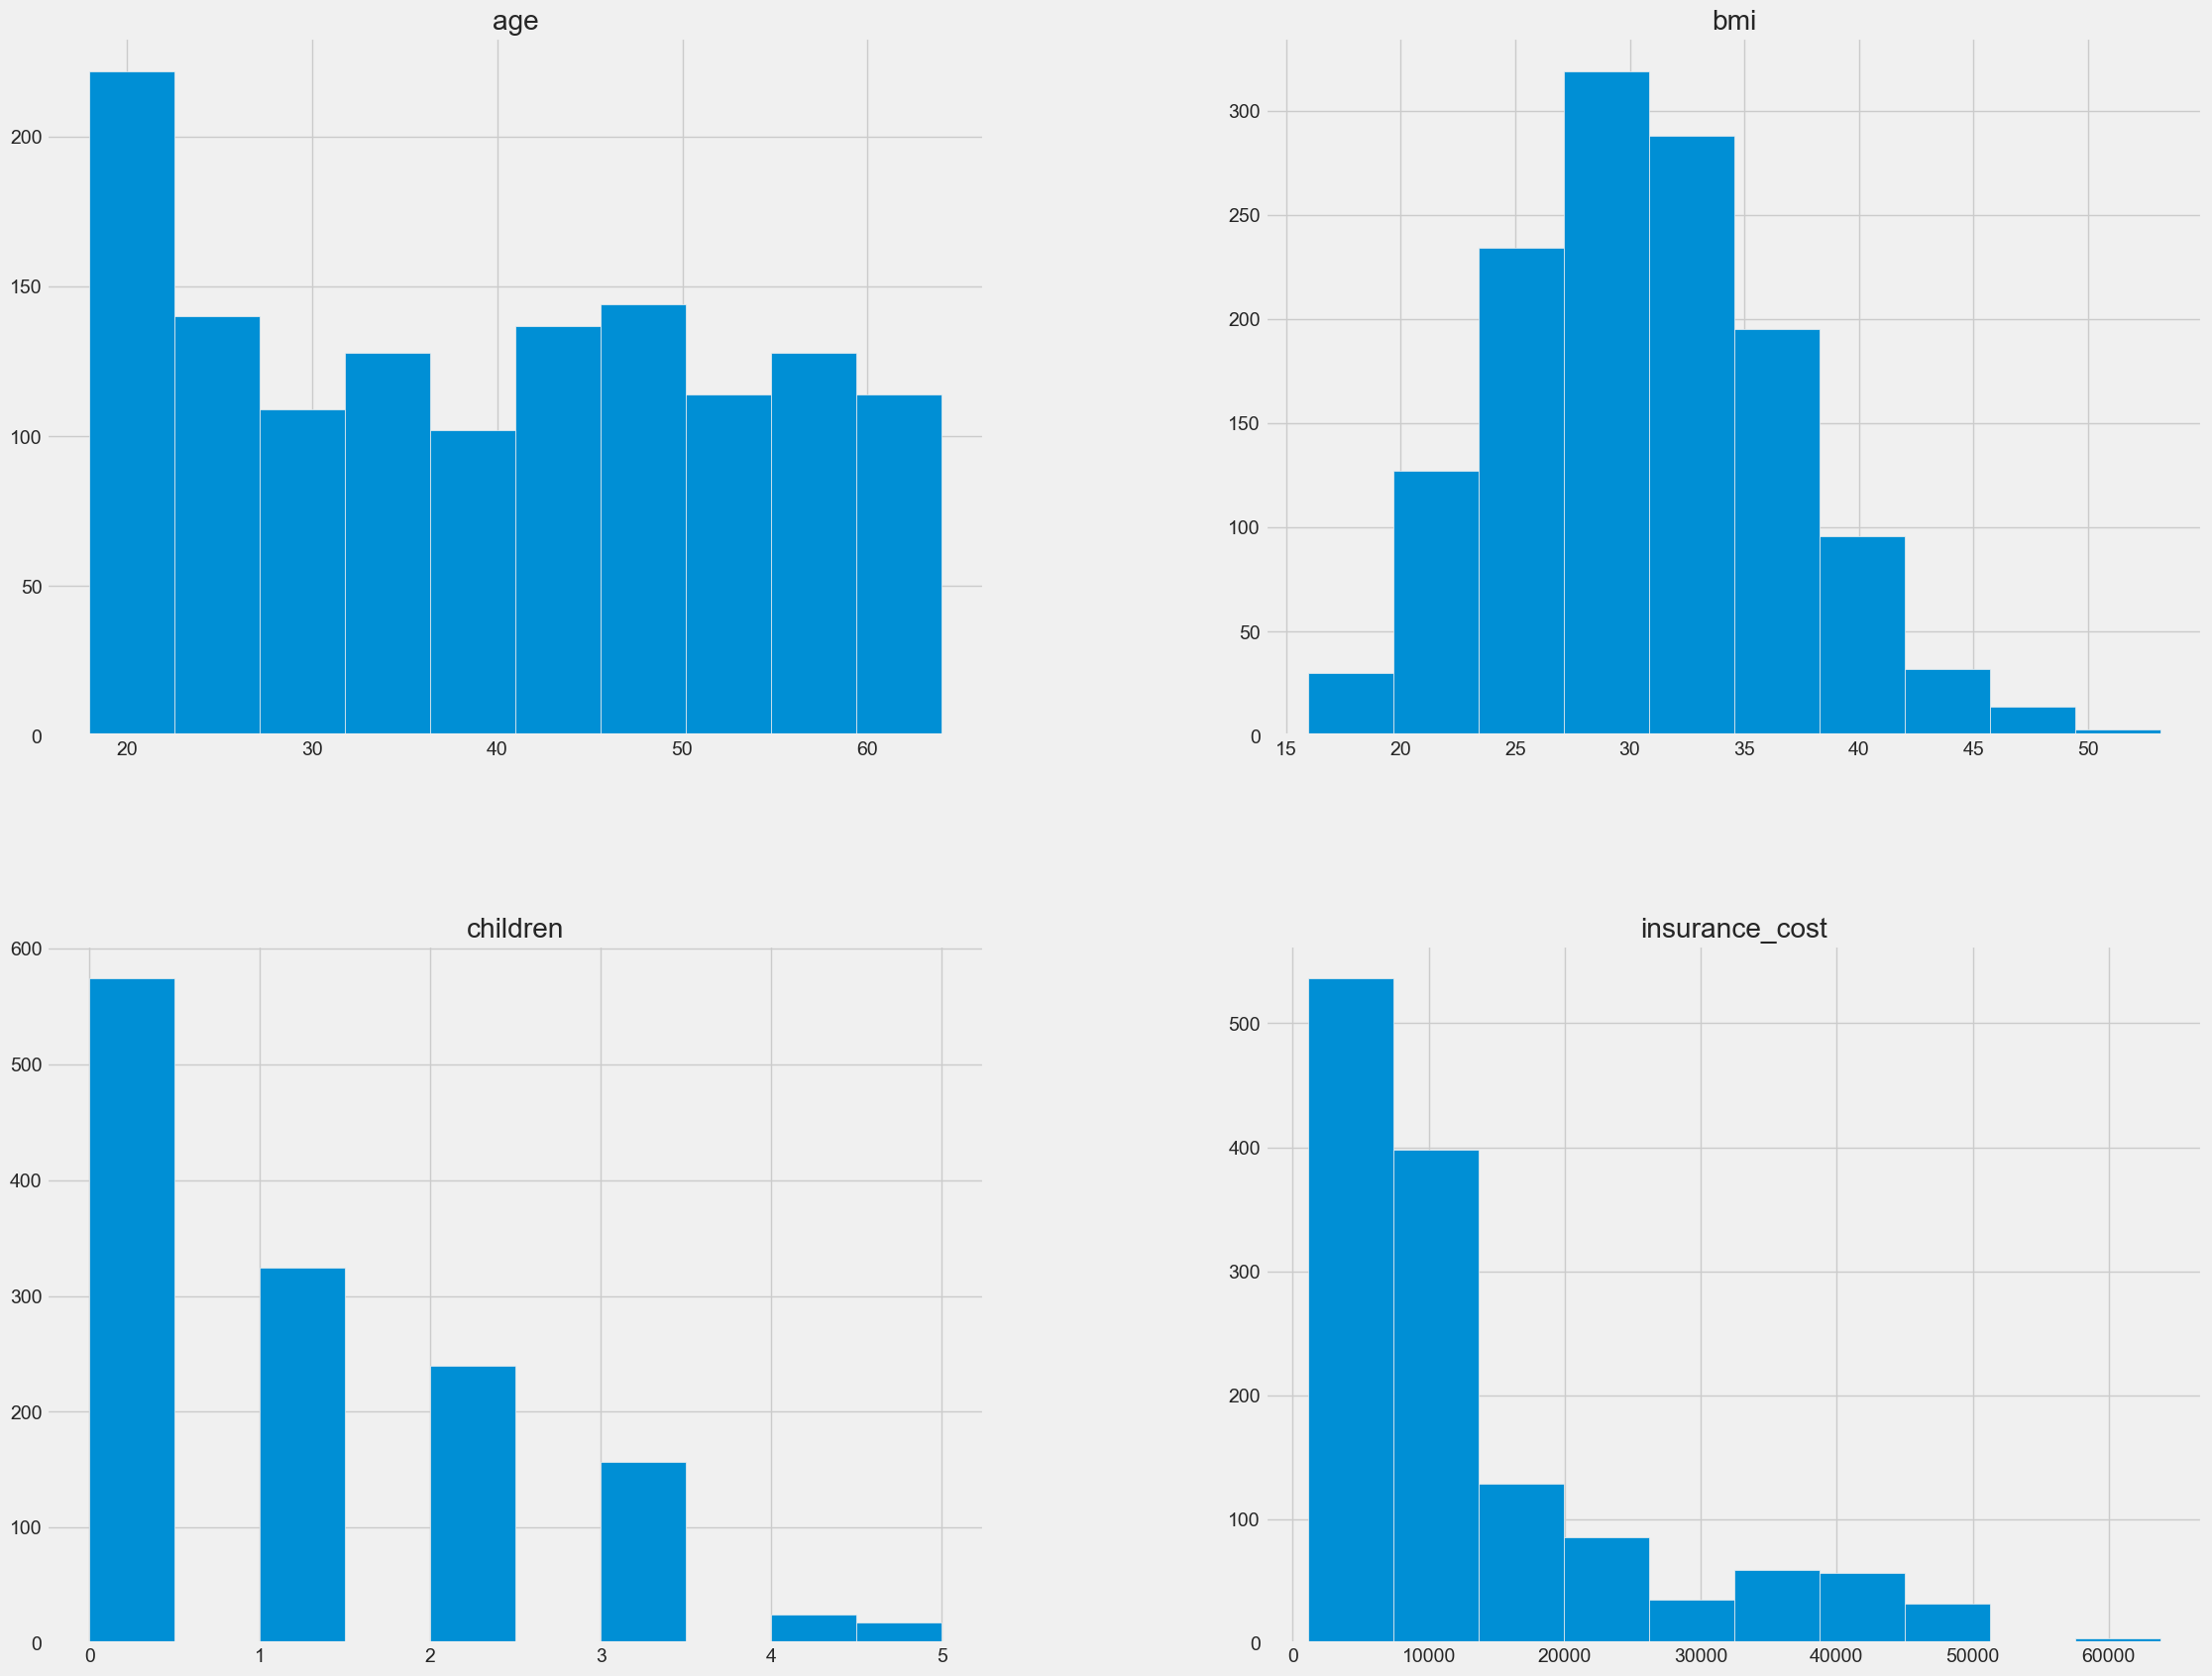

In [156]:
df.select_dtypes(include='number').hist(bins=10, figsize=(25, 20))
plt.show()

|Type| Attribute | Has Zeros | Outliers | Skewed | Map Values | Imput | Scale| One Hot Encode |Comment|
|-----|-----------|----------|----------|--------|------------|-------|------|----------------|----|
|| Age       | No| No |        | No         |            |       | |                | ||
|| Bmi       | No| Yes |        | No         |            |       | |                | ||
|| Children  | Yes|No| Right  | No         |            |       | |                | ||
|| Gender    | No ||        | Yes        |            |       |       |       |                | ||
|| Region    | No   | |        | Yes               |            |       |       |       |                | ||
|| Smoker    | No    ||        | Yes    |            |            |       | |                | ||

Pipeline

In [157]:
def map_gender(X):
	X = X.copy()
	X['gender'] = X['gender'].map({'male': 0, 'female': 1})
	return X


def map_smoker(X):
	X = X.copy()
	X['smoker'] = X['smoker'].map({'no': 0, 'yes': 1})
	return X


smoker_mapper = FunctionTransformer(map_smoker)
gender_mapper = FunctionTransformer(map_gender)


In [158]:


###################
num_pipeline = Pipeline(steps=[

	('address_right_skew', ColumnTransformer(
		transformers=[
			('log_transform', FunctionTransformer(np.log1p), ['children'])
		],
		remainder="passthrough"
	)
	 ),
	('scaler', StandardScaler())
]
)

cat_pipeline = Pipeline(steps=[
	('attribute_mappers', ColumnTransformer(
		transformers=[
			('gender_mapper', gender_mapper, ['gender']),
			('smoker_mapper', smoker_mapper, ['smoker'])
		]
	)),
	('one-hot', OneHotEncoder(sparse_output=False))  # sparse output required for fit_transform
])

#
# Use a col transformer to operate on each set separately
#
col_transform = ColumnTransformer(transformers=[
	('num_pipeline', num_pipeline, numerical_attribute),
	('cat_pipeline', cat_pipeline, categorical_attribute)
], remainder='drop', n_jobs=-1)

# create the actual pipeline
preprocess_pipeline = Pipeline(steps=[
	('preprocess', col_transform),

])


In [159]:
median_cost = df['insurance_cost'].median()

print(f"Median Cost {median_cost}")

# compare cost against median, convert True / false to 1 / 0
df['insurance_cost_binary'] = (df['insurance_cost'] > median_cost).astype(int)
df.drop('insurance_cost', axis=1, inplace=True)

y = df['insurance_cost_binary'];
X = df.drop('insurance_cost_binary', axis=1);

print(df)

# check that binary added correctly
binary_counts = df['insurance_cost_binary'].value_counts();
print(binary_counts)

Median Cost 9382.033
      age  gender     bmi  children smoker     region  insurance_cost_binary
0      18    male  33.770         1     no  southeast                      0
1      18    male  34.100         0     no  southeast                      0
2      18  female  26.315         0     no  northeast                      0
3      18  female  38.665         2     no  northeast                      0
4      18  female  35.625         0     no  northeast                      0
...   ...     ...     ...       ...    ...        ...                    ...
1333   64  female  31.825         2     no  northeast                      1
1334   64  female  26.885         0    yes  northwest                      1
1335   64    male  26.410         0     no  northeast                      1
1336   64    male  36.960         2    yes  southeast                      1
1337   64    male  23.760         0    yes  southeast                      1

[1338 rows x 7 columns]
insurance_cost_binary
0    669

In [160]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Dimension Reduction Setup

In [161]:

N_FEATURES_OPTIONS = [2, 4, 5, 7]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

dim_reduction_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
	}
]


### SVM Classification Pipeline

In [162]:

# create the pipeline
svm_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('svm', svm.SVC(probability=True))
])

In [163]:
set_config(display="diagram")
svm_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x319d00680>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x319d03420>),
                                                                                                                     ['smoker'])])),
                                                                                   ('one-hot',
                                                                                    OneHotEncoder(sparse_output=False))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'), ('svm', SVC(probability=True))])

In [164]:


svm_grid_params = [
	{
		'svm__C': [0.1, 1, 10],  # , 100
		'svm__gamma': [1, 0.1, 0.01],  #, 0.001
		'svm__kernel': ['rbf', 'linear', 'poly'],

		'reduce_dim': [RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

	},
	{
		'svm__C': [0.1, 1, 10],  # , 100
		'svm__gamma': [1, 0.1, 0.01],  #, 0.001
		'svm__kernel': ['rbf', 'linear', 'poly'],

		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,

	}
]

search = GridSearchCV(svm_pipe, svm_grid_params, n_jobs=-1, cv=5, refit=True)

search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.939:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression()), 'reduce_dim__n_features_to_select': 5, 'svm__C': 1, 'svm__gamma': 1, 'svm__kernel': 'rbf'}


### Random Forest Classification Pipeline

In [165]:


random_forest_pipe = Pipeline(steps=[('preprocess', preprocess_pipeline),
									 ('reduce_dim', 'passthrough'),
									 ('random_forest', RandomForestClassifier(n_estimators=100, random_state=42))

									 ]
							  )
set_config(display="diagram")
random_forest_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x319d00680>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x319d03420>),
                                                                                                                     ['smoker'])])),
                                                                                   ('one-hot',
                                                                                    OneHotEncoder(sparse_output=False))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('random_forest', RandomForestClassifier(random_state=42))])

In [166]:
random_forest_grid_params = [{

	'reduce_dim': [PCA(iterated_power=7)],
	'reduce_dim__n_components': N_FEATURES_OPTIONS,

},
	{

		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,

	}]

search = GridSearchCV(random_forest_pipe, random_forest_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
random_forest_best_params = search.best_params_
random_forest_best_model = search.best_estimator_

Best CV score = 0.924:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}


### kNN Classification Pipeline

In [167]:
# create the pipeline
knn_pipe = Pipeline(steps=[
	('preprocess', preprocess_pipeline),
	('reduce_dim', 'passthrough'),
	('knn', KNeighborsClassifier())
])

set_config(display="diagram")
knn_pipe

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(n_jobs=-1,
                                                    transformers=[('num_pipeline',
                                                                   Pipeline(steps=[('address_right_skew',
                                                                                    ColumnTransformer(remainder='passthrough',
                                                                                                      transformers=[('log_transform',
                                                                                                                     FunctionTransformer(func=<ufunc 'log1p'>),
                                                                                                                     ['children'])])),
                                                                                   ('scaler',
                                                                                    StandardScaler())]),
                                                                   ['age',
                                                                    'bmi',
                                                                    'children']),
                                                                  ('cat_p...
                                                                                    ColumnTransformer(transformers=[('gender_mapper',
                                                                                                                     FunctionTransformer(func=<function map_gender at 0x319d00680>),
                                                                                                                     ['gender']),
                                                                                                                    ('smoker_mapper',
                                                                                                                     FunctionTransformer(func=<function map_smoker at 0x319d03420>),
                                                                                                                     ['smoker'])])),
                                                                                   ('one-hot',
                                                                                    OneHotEncoder(sparse_output=False))]),
                                                                   ['gender',
                                                                    'smoker',
                                                                    'region'])]))])),
                ('reduce_dim', 'passthrough'),
                ('knn', KNeighborsClassifier())])

In [168]:



knn_grid_params = [
	{
		'reduce_dim': [PCA(iterated_power=7)],
		'reduce_dim__n_components': N_FEATURES_OPTIONS,
		'knn__n_neighbors': list(range(1, 21))
	},
	{
		'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
		'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
		'knn__n_neighbors': list(range(1, 21))
	},
	{
		'reduce_dim': [SelectKBest(score_func=f_classif, k=5)],
		'knn__n_neighbors': list(range(1, 21))
	},
]

search = GridSearchCV(knn_pipe, knn_grid_params, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)  #training happens here! SVM is trained 48x5 = 240 times

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
knn_best_params = search.best_params_
knn_best_model = search.best_estimator_


Best CV score = 0.938:
Best parameters:  {'knn__n_neighbors': 15, 'reduce_dim': RFE(estimator=SVR(gamma='auto', kernel='linear')), 'reduce_dim__n_features_to_select': 4}


## Compare Classification Models on Test Set

In [169]:


# model - a trained binary probabilistic classification model;
#         it is assumed that there are two classes: 0 and 1
#         and the model predicts probabilities for the examples to belong to class 1

def evaluate_model(X_test, y_test, model):
	# compute probabilistic predictiond for the evaluation set
	_probabilities = model.predict_proba(X_test)[:, 1]

	# compute exact predictiond for the evaluation set
	_predicted_values = model.predict(X_test)

	# compute accuracy
	_accuracy = accuracy_score(y_test, _predicted_values)

	# compute precision, recall and f1 score for class 1
	_precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])

	# compute fpr and tpr values for various thresholds
	# by comparing the true target values to the predicted probabilities for class 1
	_fpr, _tpr, _ = roc_curve(y_test, _probabilities)

	# compute true positive rates for the values in the array mean_fpr
	_tpr_transformed = np.array([np.interp(mean_fpr, _fpr, _tpr)])

	# compute the area under the curve
	_auc = auc(_fpr, _tpr)

	return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [170]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [171]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test,
																				   random_forest_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, knn_best_model)

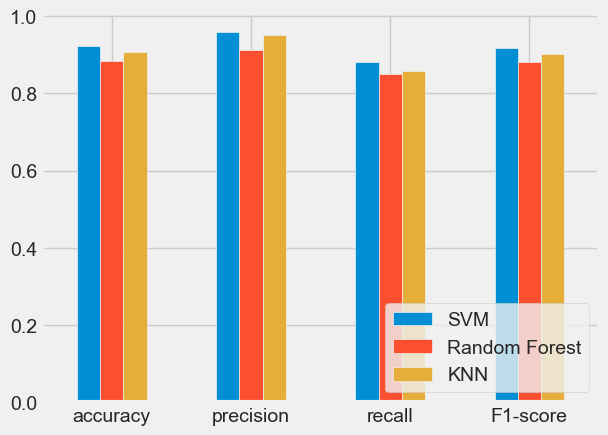

In [172]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])
index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics, 'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

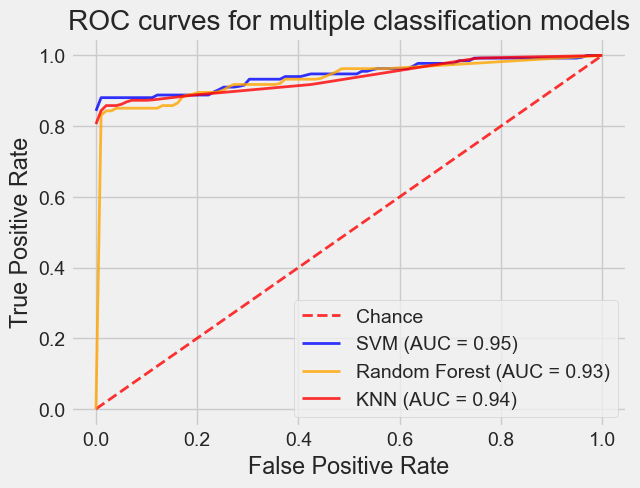

In [173]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0, :], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0, :], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0, :], lw=2, color='red', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classification models')
plt.legend(loc="lower right")
plt.show()

#### Data Dictionary / Columns (https://www.kaggle.com/datasets/mirichoi0218/insurance)

1. age: age of primary beneficiary
1. sex: insurance contractor gender, female, male
1. bmi: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
1. children: Number of children covered by health insurance / Number of dependents
1. smoker: Smoking
1. region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
1. charges: Individual medical costs billed by health insurance